# Predicción de aprobación curso de matematicas mediante redes neuronales


---------
* Juan Esteban Ortiz - 2410227-3743
* Juan David Olaya - 202410206-3743
* Pablo Esteban Becerra - 202243506 - 3743
* Fernando Cardona Giraldo - 202241381-3743
* Sara Yineth Suarez Reyes - 202241923-3743


Para la experimentación con técnicas de machine learning se empleará un conjunto de datos 
compuesto por 1044 personas que participaron en un estudio orientado a predecir si aprueban un curso 
de matemáticas. La información recopilada incluye variables como edad, sexo, ocupación de la madre 
y del padre, tiempo de estudio semanal, acceso a internet y otros datos relevantes. Cada estudiante 
está descrito mediante los 17 atributos. La variable dependiente es 
approved, que toma el valor 1 cuando el estudiante aprueba el curso y 0 en caso contrario. En este 
informe se desarrollan modelos para predecir dicha variable a partir de los demás atributos, abordando 
el problema como una tarea de clasificación. 

*   Se cargan las bibliotecas que se usarán

In [1]:
import sklearn
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
warnings.filterwarnings('ignore')

* Lectura de datos

In [2]:
dataFrame=pd.read_csv('student_performance.csv')
dataFrame

,sex,age,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,traveltime,studytime,failures,internet,romantic,goout,Walc,health,approved
0,F,18,GT3,A,4,4,at_home,teacher,2,2,0,no,no,4,1,3,0
1,F,17,GT3,T,1,1,at_home,other,1,2,0,yes,no,3,1,3,0
2,F,15,LE3,T,1,1,at_home,other,1,2,3,yes,no,2,3,3,1
3,F,15,GT3,T,4,2,health,services,1,3,0,yes,yes,2,1,5,1
4,F,16,GT3,T,3,3,other,other,1,2,0,no,no,2,2,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,F,19,GT3,T,2,3,services,other,1,3,1,yes,no,2,2,5,1
1040,F,18,LE3,T,3,1,teacher,services,1,2,0,yes,no,4,1,1,1
1041,F,18,GT3,T,1,1,other,other,2,2,0,no,no,1,1,5,0
1042,M,17,LE3,T,3,1,services,services,2,1,0,yes,no,5,4,2,1


In [3]:
dataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sex         1044 non-null   object
 1   age         1044 non-null   int64 
 2   famsize     1044 non-null   object
 3   Pstatus     1044 non-null   object
 4   Medu        1044 non-null   int64 
 5   Fedu        1044 non-null   int64 
 6   Mjob        1044 non-null   object
 7   Fjob        1044 non-null   object
 8   traveltime  1044 non-null   int64 
 9   studytime   1044 non-null   int64 
 10  failures    1044 non-null   int64 
 11  internet    1044 non-null   object
 12  romantic    1044 non-null   object
 13  goout       1044 non-null   int64 
 14  Walc        1044 non-null   int64 
 15  health      1044 non-null   int64 
 16  approved    1044 non-null   int64 
dtypes: int64(10), object(7)
memory usage: 138.8+ KB


# Se separan los datos en entrenamiento y prueba
80% para entrenar y 20% para pruebas


In [4]:
train_data,test_data=sklearn.model_selection.train_test_split(dataFrame, test_size=0.2)
print(len(train_data),len(test_data))

835 209


In [5]:
train_data.head(5)

,sex,age,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,traveltime,studytime,failures,internet,romantic,goout,Walc,health,approved
457,F,16,LE3,T,1,2,other,services,1,2,0,yes,no,3,1,1,1
881,F,16,GT3,T,2,2,other,services,1,1,1,yes,no,3,4,3,1
243,M,16,GT3,T,4,4,services,services,1,1,0,yes,no,2,2,5,1
370,F,19,LE3,T,3,2,services,services,2,2,2,no,yes,2,1,3,0
532,F,16,GT3,A,2,2,other,other,1,1,1,no,no,4,1,5,1


# Pipeline para los atributos categóricos

In [6]:
# 7 atributos categóricos
cat_attribs = ['sex','famsize','Pstatus','Mjob','Fjob','internet','romantic']

cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse_output=False))
    ])

# Pipeline para los atributos numéricos

In [7]:
# 9 atributos numéricos
num_attribs = ['age','Medu','Fedu','traveltime','studytime','failures','goout','Walc','health']

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

# Pipeline completo

In [8]:
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

In [9]:
X_train = full_pipeline.fit_transform(train_data)

In [10]:
X_train.shape

(835, 29)

In [11]:
X_train[0,:]

array([-0.58644388, -1.42553581, -0.370974  , -0.71566706,  0.02467071,
       -0.40020524, -0.1218257 , -0.99614749, -1.79576342,  1.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  1.        ,  1.        ,  0.        ])

In [12]:
y_train = train_data["approved"]
y_train

457    1
881    1
243    1
370    0
532    1
      ..
771    1
505    1
348    1
288    1
893    1
Name: approved, Length: 835, dtype: int64

# Entrenamiento de las redes neuronales


In [43]:
# funciones de activacion: identity’, ‘logistic’, ‘tanh’, ‘relu’
# solver: ‘lbfgs’, ‘sgd’, ‘adam’
modelo1 = MLPClassifier(activation='relu',solver='lbfgs', hidden_layer_sizes=(10,5))
modelo1.fit(X_train, y_train)

,hidden_layer_sizes,"(10, ...)"
,activation,'relu'
,solver,'lbfgs'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,200
,shuffle,True
,random_state,None


In [44]:
modelo2 = MLPClassifier(activation='identity',solver='sgd', hidden_layer_sizes=(5,6,7), learning_rate='invscaling')
modelo2.fit(X_train, y_train)

,hidden_layer_sizes,"(5, ...)"
,activation,'identity'
,solver,'sgd'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'invscaling'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,200
,shuffle,True
,random_state,None


In [45]:
modelo3 = MLPClassifier(activation='logistic',solver='adam', hidden_layer_sizes=(8,3,2,6))
modelo3.fit(X_train, y_train)

,hidden_layer_sizes,"(8, ...)"
,activation,'logistic'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,200
,shuffle,True
,random_state,None


In [46]:
modelo4 = MLPClassifier(activation='tanh',solver='lbfgs', hidden_layer_sizes=(20))
modelo4.fit(X_train, y_train)

,hidden_layer_sizes,20
,activation,'tanh'
,solver,'lbfgs'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,200
,shuffle,True
,random_state,None


In [47]:
modelo5 = MLPClassifier(activation='relu',solver='sgd', hidden_layer_sizes=(3,5,7,9,10))
modelo5.fit(X_train, y_train)

,hidden_layer_sizes,"(3, ...)"
,activation,'relu'
,solver,'sgd'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,200
,shuffle,True
,random_state,None


# Uso de los modelos entrenados

In [48]:
X_test = full_pipeline.transform(test_data)
Y_test = test_data["approved"]

In [49]:
predicciones1 = modelo1.predict(X_test)
predicciones2 = modelo2.predict(X_test)
predicciones3 = modelo3.predict(X_test)
predicciones4 = modelo4.predict(X_test)
predicciones5 = modelo5.predict(X_test)

*   Se calcula el accuracy

In [50]:
accuracy1 = accuracy_score(Y_test, predicciones1)
accuracy2 = accuracy_score(Y_test, predicciones2)
accuracy3 = accuracy_score(Y_test, predicciones3)
accuracy4 = accuracy_score(Y_test, predicciones4)
accuracy5 = accuracy_score(Y_test, predicciones5)

In [51]:
resultados = {
    'Técnica': ['Modelo 1','Modelo 2','Modelo 3','Modelo 4','Modelo 5'],
    'Accuracy': [accuracy1,accuracy2,accuracy3,accuracy4,accuracy5],
}

# Crear el DataFrame
tabla_resultados = pd.DataFrame(resultados)

# Mostrar la tabla con 4 decimales
tabla_resultados = tabla_resultados.round(4)
tabla_resultados

,Técnica,Accuracy
0,Modelo 1,0.7512
1,Modelo 2,0.7273
2,Modelo 3,0.7656
3,Modelo 4,0.7225
4,Modelo 5,0.7656


* En la ejecución inicial los hiperparametros que permiten encontrar el mejor accuracy son: activation='identity',solver='sgd', hidden_layer_sizes=(5,6,7) con un accuraccy de 0.8182 en el **modelo 2**. A continuación hay una grafica con esta primera ejecución:

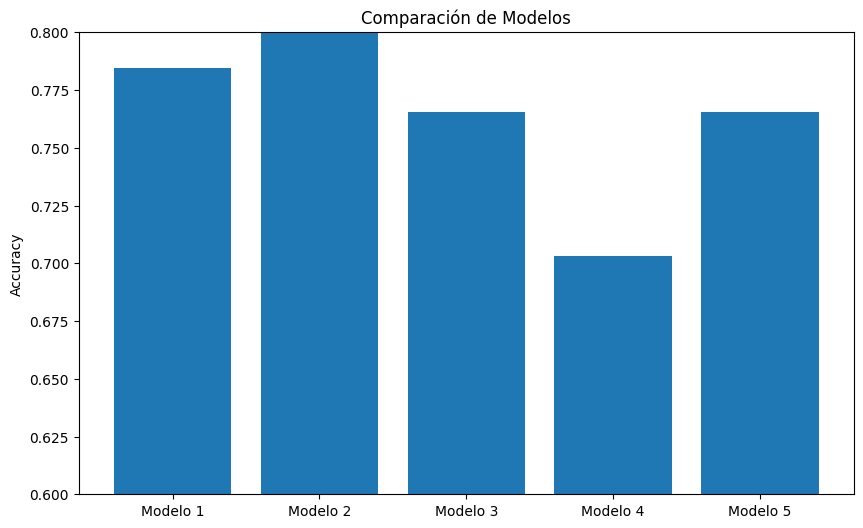

#### Se escogió el hiperparametro learning_rate y luego de agregarlo podemos concluir que en el modelo 2:
* Agregando el hiperparametro de **learning_rate=constant** el accuracy subió a 0.8278. 
* Modificando el **learning_rate=apative** el accuracy fue menor al valor inicial y a la modificación anterior con un valor de 0.8086.
* Modificando el hiperparametro a **learning_rate=invscaling** el accuracy bajó a 0.7273 siendo este el valor mas bajo de todas las ejecuciones.
* Con estas pruebas podemos ver como en solo una de las modificaciones(**learning_rate=constat**) el accuracy superó a la ejecución inicial sin el nuevo hiperparametro y en los demas casos bajó. A continuacion hay una grafica con la ultima ejecución.

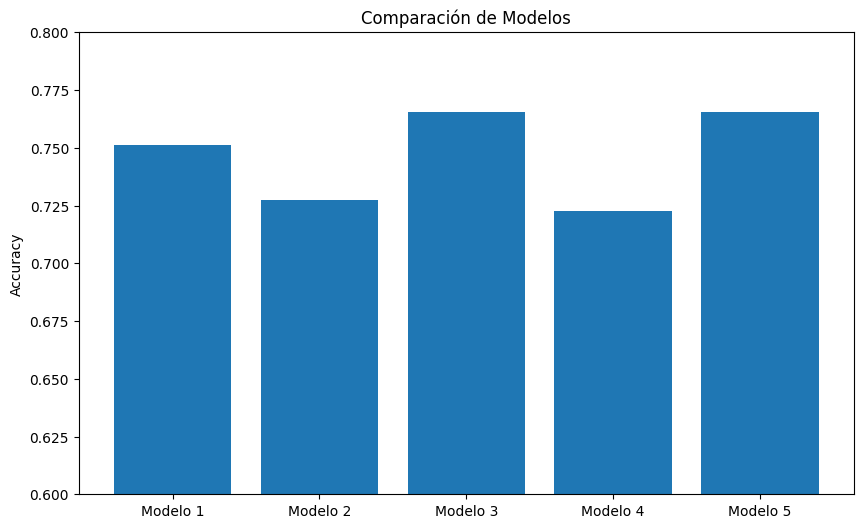

In [52]:
modelos = ['Modelo 1', 'Modelo 2', 'Modelo 3', 'Modelo 4', 'Modelo 5']
accuracies = [accuracy1, accuracy2, accuracy3, accuracy4, accuracy5]

plt.figure(figsize=(10, 6))
plt.bar(modelos, accuracies)
plt.ylabel('Accuracy')
plt.title('Comparación de Modelos')
plt.ylim([0.6, 0.8])
plt.show()